In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline



In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV, Lasso

import patsy

In [3]:
def pred_target(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    X = df[[x for x in df.columns if x != 'price']]
    y = df.price.values
    target = np.log(y)
    formula = "target ~ "+' + '.join([x for x in df.columns if not x =='price'])+' -1'
    y, X = patsy.dmatrices(formula, data=df, return_type='dataframe')
    y = y.values.ravel()
    return X, y
    

In [4]:
barcelona = pd.read_csv('/Users/jyots/Desktop/DS_Projects/airbnb_DataSets/Barcelona_dfm.csv',
                   encoding='utf8')

In [5]:
X, y = pred_target(barcelona)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [7]:
X_train.shape, X_test.shape

((9729, 23), (4170, 23))

In [8]:
linmod = LinearRegression()

In [9]:
scores = cross_val_score(linmod, X_train, y_train, cv = 10)
print scores
print np.mean(scores)
print np.std(scores)

[ 0.64537739  0.65847563  0.63102397  0.64065854  0.60083283  0.58996948
  0.1169169   0.65284964  0.60851804  0.62577564]
0.57703980488
0.154862202971


In [10]:
predictions = cross_val_predict(linmod, X_test, y_test, cv = 10) 
accuracy = metrics.r2_score(y_test, predictions)
print accuracy


0.613012800348


In [11]:
residuals = y_test - predictions
residuals

array([ 0.16472006,  0.43771166,  0.37086123, ...,  0.3570492 ,
       -0.12657951, -0.15548291])

In [12]:
np.mean(predictions)


4.2063928388245193

In [13]:
linmod.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
linmod.score(X_test, y_test)

0.60990429524877254

In [15]:
#linmod.coef_

In [16]:
print np.mean(y_train), np.mean(y_test)

4.19966981087 4.20623982962


In [17]:
# Regularization: Gridsearch an optimal ElasticNet regression

In [18]:
Xn = StandardScaler().fit_transform(X)

In [19]:
Xn_train, Xn_test, y_train, y_test = train_test_split(Xn, y, test_size = 0.3)

In [20]:
# enet_cv = ElasticNetCV(l1_ratio=np.linspace(0.01, 1., 50), n_alphas=300, cv=10, verbose=1)
# enet_cv.fit(Xn_train, y_train)


In [21]:
# print enet_cv.l1_ratio_
# print enet_cv.alpha_

In [22]:
# enet = ElasticNet(alpha= enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_)

# y_pred_enet = enet.fit(Xn_train, y_train).predict(Xn_test)
# r2_score_enet = metrics.r2_score(y_test, y_pred_enet)
# print(enet)
# print("r^2 on test data : %f" % r2_score_enet)


In [23]:
lassocv = LassoCV(n_alphas=300, cv=10)

In [24]:
lassocv.fit(Xn_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=300, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [25]:
lassocv.alpha_

0.018729954508480008

In [26]:
lasso = Lasso(alpha=lassocv.alpha_)

y_pred_lasso = lasso.fit(Xn_train, y_train).predict(Xn_test)
r2_score_lasso = metrics.r2_score(y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)


Lasso(alpha=0.018729954508480008, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : 0.609906


In [27]:
residuals = y_test - y_pred_lasso

In [28]:
lasso.fit(Xn_train, y_train)

lasso_coef = pd.DataFrame({
        'variable':X_train.columns,
        'coef':lasso.coef_,
        'abscoef':np.abs(lasso.coef_)
    })

lasso_coef.sort_values('abscoef', ascending=False, inplace=True)
lasso_coef[lasso_coef.coef != 0].head(25)


,abscoef,coef,variable
10,0.391650,-0.391650,room_type[T.Private room]
13,0.113896,0.113896,bedrooms
11,0.107449,-0.107449,room_type[T.Shared room]
21,0.058789,-0.058789,reviews
14,0.048762,0.048762,bhk
12,0.048210,0.048210,bathrooms
16,0.040388,0.040388,host_count
5,0.024941,-0.024941,neighborhood[Nou Barris]
6,0.011401,-0.011401,neighborhood[Sant Andreu]
9,0.010149,0.010149,neighborhood[Sarria-Sant Gervasi]


In [30]:
# plt.plot(enet.coef_, color='lightgreen', linewidth=2,
#          label='Elastic net coefficients')
# plt.plot(lassocv.coef_, color='gold', linewidth=2,
#          label='Lasso coefficients')
# #plt.plot(linmod.coef_, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()

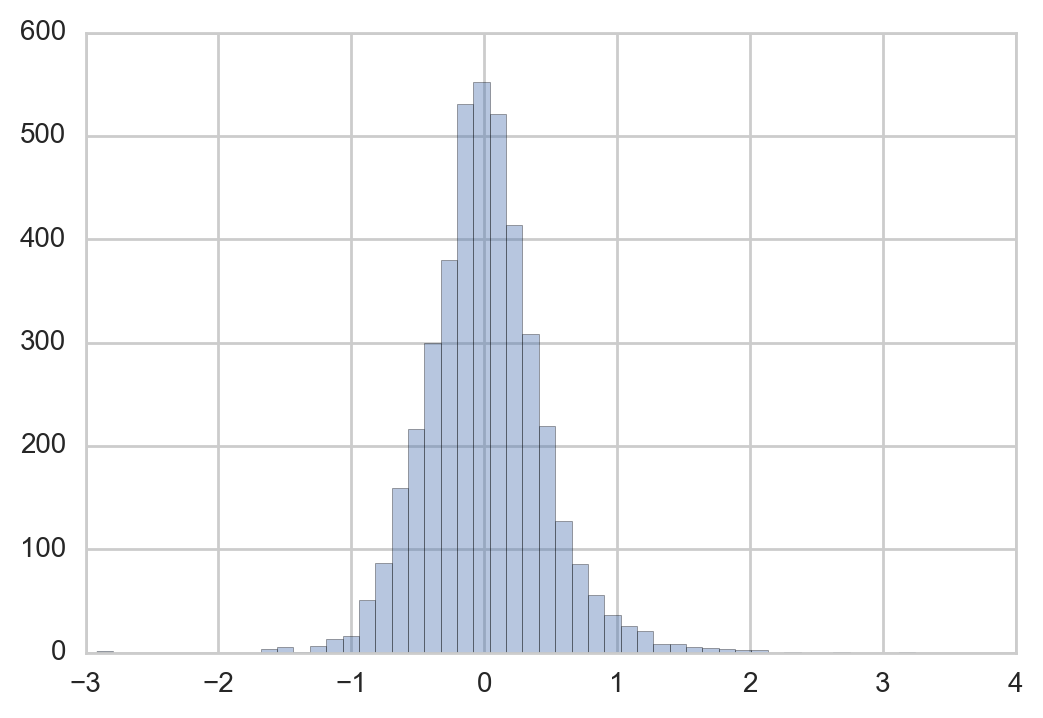

In [31]:
# plt.plot(residuals, '--', color='navy', label='original coefficients')
# plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
#           % (r2_score_lasso, r2_score_enet))
# plt.show()
sns.distplot(residuals, bins=50, kde=False)